<a href="https://colab.research.google.com/github/jaydeepthik/Graph-Neural-Nets/blob/main/gnn_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'scipy>=1.8'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import networkx as nx

In [3]:
nx.__version__

'3.0'

# Download Cora Dataset

In [4]:
cora_dataset = keras.utils.get_file(fname="cora.tgz", origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",extract=True)
data_dir = os.path.join(os.path.dirname(cora_dataset), "cora")
print(data_dir)

168052/168052 [==============================] - 0s 3us/step
/root/.keras/datasets/cora


In [5]:
#loading citations data
citations_data = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep="\t", header=None, names=["Target", "Source"])
print(citations_data.shape)
citations_data.head()

(5429, 2)


,Target,Source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [6]:
citations_data.sample(frac=1).head()

,Target,Source
991,4330,4329
3558,70442,1107215
4936,521269,1125993
1440,6898,78994
2090,16485,1123087


In [7]:
#loading papers data
paper_data_cols = ["Paper_ID"] + [f"Feat_{idx}" for idx in range(1433)] + ["Subject"]
paper_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=paper_data_cols)
paper_data.shape

(2708, 1435)

In [8]:
#num papers in each subject
paper_data["Subject"].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: Subject, dtype: int64

# Preprocessing

In [9]:
#encode paper_ids and subjects
unique_subjects = sorted(paper_data["Subject"].unique())
unique_paper_IDs = sorted(paper_data["Paper_ID"].unique())

subject2idx = {cls:idx for idx, cls in enumerate(unique_subjects)}
paper2idx = {paper_id: idx for idx, paper_id in enumerate(unique_paper_IDs)}

#convert
paper_data["Paper_ID"] = paper_data["Paper_ID"].apply(lambda x: paper2idx[x])
paper_data["Subject"] = paper_data["Subject"].apply(lambda x: subject2idx[x])

citations_data["Source"] = citations_data["Source"].apply(lambda x: paper2idx[x])
citations_data["Target"] = citations_data["Target"].apply(lambda x: paper2idx[x])

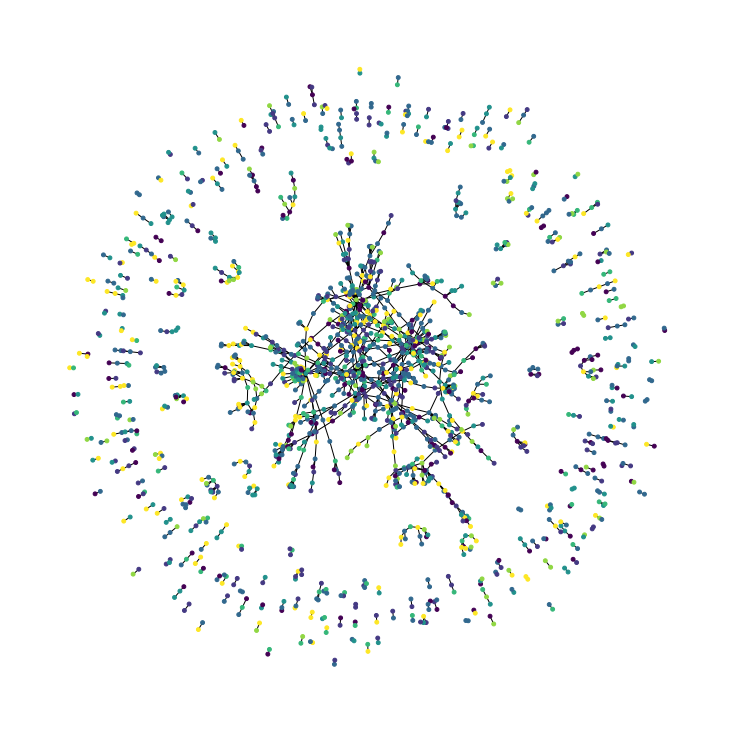

In [10]:
plt.figure(figsize=(10, 10))
colors = paper_data["Subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations_data.sample(n=1500), "Source", "Target")
subjects = list(paper_data[paper_data["Paper_ID"].isin(list(cora_graph.nodes))]["Subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [11]:
#split data into stratified train and test set based on Subject
train_data, test_data = [], []

for _, subject_data in paper_data.groupby("Subject"):
  shuffled_idx = np.random.rand(len(subject_data)) <=0.5
  train_data.append(subject_data[shuffled_idx])
  test_data.append(subject_data[~shuffled_idx])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print(train_data.shape, test_data.shape)

(1363, 1435) (1345, 1435)


# Training GNN

In [12]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [13]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)



## GNN model
graph data represented by tuple `graph_info`


1.   `node_features`: `[n_nodes, n_features]` -> papers
2.   `edges`: `[n_edges, n_edges]` -> citations b/w papers
3.   `edge_weights`: `[num_edges]` -> None/ all 1's



In [14]:
feature_names = set(paper_data.columns) - {"Paper_ID", "Subject"}
num_features = len(feature_names)
num_classes = len(subject2idx)
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["Subject"]
y_test = test_data["Subject"]

#sparse adjacency matrix of edges [2, num_edges]
edges = citations_data[["Source", "Target"]].to_numpy().T

#edge weights
edge_weights = tf.ones(shape=edges.shape[1])

#create node_features

node_features = tf.cast(
    paper_data.sort_values("Paper_ID")[feature_names].to_numpy(),
    dtype=tf.dtypes.float32
)

graph_info = (node_features, edges, edge_weights)

print(edges.shape, node_features.shape)

(2, 5429) (2708, 1433)


In [15]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [16]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [17]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.065356   -0.06501153 -0.08406217  0.08677422 -0.09657428 -0.04552495
  -0.01283256]
 [ 0.08585953 -0.16449541 -0.14601626  0.04950012 -0.1339304   0.02803905
  -0.01695458]
 [-0.04607152  0.00045053  0.02981886  0.04282838 -0.02519387 -0.16202426
   0.00785922]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

In [18]:
x_train = train_data.Paper_ID.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 10s 558ms/step - loss: 2.2157 - acc: 0.1969 - val_loss: 1.9025 - val_acc: 0.2683
Epoch 2/300
5/5 [==============================] - 1s 290ms/step - loss: 1.9893 - acc: 0.2297 - val_loss: 1.8932 - val_acc: 0.2732
Epoch 3/300
5/5 [==============================] - 1s 190ms/step - loss: 1.9271 - acc: 0.2746 - val_loss: 1.8928 - val_acc: 0.2780
Epoch 4/300
5/5 [==============================] - 1s 190ms/step - loss: 1.8966 - acc: 0.2919 - val_loss: 1.8969 - val_acc: 0.2780
Epoch 5/300
5/5 [==============================] - 1s 198ms/step - loss: 1.8670 - acc: 0.3014 - val_loss: 1.8956 - val_acc: 0.2780
Epoch 6/300
5/5 [==============================] - 1s 188ms/step - loss: 1.8249 - acc: 0.3074 - val_loss: 1.8878 - val_acc: 0.2780
Epoch 7/300
5/5 [==============================] - 1s 187ms/step - loss: 1.8460 - acc: 0.2988 - val_loss: 1.8775 - val_acc: 0.2780
Epoch 8/300
5/5 [==============================] - 1s 184ms/step - loss: 1.8322 - 

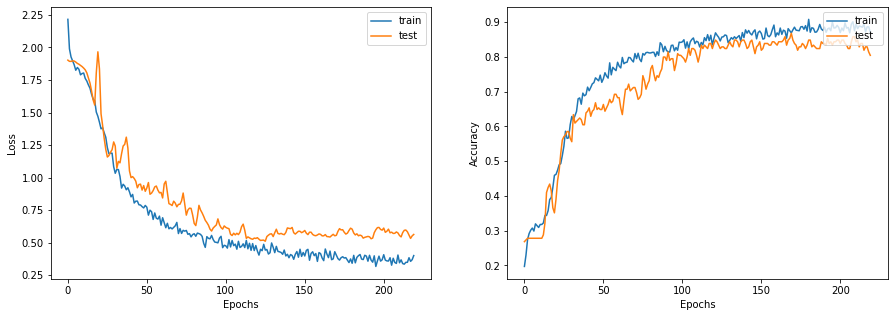

In [19]:
display_learning_curves(history)

In [20]:
x_test = test_data.Paper_ID.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 83.35%
